This script is used for processing scrubber life data. This requires 
prior usage of the program for sychronizing the valve state data with the
data file in question. 

In [1]:
#1.1 Setup - module import/other setup

%pylab
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,12)
from __future__ import division
import sys
#sys.path.append('../')
#sys.path.append('../Lab_Scripts_WI/analysis/')   # For Simon's repo
import csv_to_data
import scipy.signal
import json
import pandas
import csv
from collections import OrderedDict, defaultdict
print
print 'Module Import Successful'

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib

Module Import Successful


In [3]:
# 2.1 Data Import Cell
# adjust the file_title variable to match the name of the file you are interested in processing. NOTICE the path for the file
# 

path = ''
# ../Lab_Scripts_WI/data/scrubber_life/ <- old path
file_title = 'test62-4__40ppm__60lpm__2S18g__DR25__20190927'    #format as 'concentration__minutevolume__everythingelse.csv'
filename = path + file_title + '.csv'

file_split = file_title.split('__')
print(file_split)
graph_title = file_split[0] + ' ' + file_split[1] + ' ' + file_split[2] + ' ' + file_split[3] + ' ' + file_split[4] + ' ' + file_split[5]
print('graph title is ',graph_title)

data_temp = pandas.read_csv(filename,header=0, dtype=np.float64) #import data as 64 bit fp
data = data_temp.to_dict(orient='list',into=OrderedDict) #convert pandas Data Frame to ordered dict
keys = data.keys()
data['ValveStates'] = map(int, data['ValveStates']) #convert the valve states to int to prevent logical comparator problems
tm = data['elapsed_time']
data['Elapsed Time'] = data['elapsed_time']
print 'Data Import Successful'
print keys

['test62-4', '40ppm', '60lpm', '2S18g', 'DR25', '20190927']
('graph title is ', 'test62-4 40ppm 60lpm 2S18g DR25 20190927')
Data Import Successful
['Unnamed: 0', 'timestamp', 'elapsed_time', 'GDN0_Iin', 'GDN0_Flow', 'GDN1_Iin', 'GDN1_Flow', 'GDN2_Iin', 'GDN2_Flow', 'GDN3_Iin', 'GDN3_Flow', 'IGTH0_PRE_temp', 'IGTH0_PRE_humid', 'IGTH0_PST_temp', 'IGTH0_PST_humid', 'IGTH3_PRE_temp', 'IGTH3_PRE_humid', 'IGTH3_PST_temp', 'IGTH3_PST_humid', 'read_err', 'Unnamed: 0.1', 'NO', 'NO_counts', 'NO2', 'NO2_counts', 'O2', 'O2_counts', 'NO_Temp', 'NO2_Temp', 'Flow', 'dpTemp', 'hTemp', 'Humid', 'ValveStates']


In [4]:
# 2.2 Configuration for Data processing/Plotting Cell

purge_state = 0
flow_lpm = 30
channel_states = sorted(numpy.unique(data['ValveStates']))
####
#Removes the purge state from the list of Valve States

for i in channel_states:
    if i == purge_state:
        channel_states = numpy.delete(channel_states,i)
print 'Purge State Designator is: %i' %purge_state
print 'Scrubber Valve State Designators are: %s' %str(channel_states)
####

scrubber_names = []
Valve2Name_dict = {}

####
#Create scubber name dictionary for plotting and data export

l = 0
for VlvKey in channel_states:
    scrubber_names.append('Scrubber'+' %i' %l)
    Valve2Name_dict[VlvKey] = ('Scrubber'+' %i' %l)
    l += 1

#future update: name these as Pre_Scrubber N and Post_Scrubber_N for each N    

print 'Scrubber Names are: %s' %scrubber_names
####


####
#Determines the size of the vector for each scrubber for preallocation to make 
#population of the vector in the analysis section more efficient

allocation_size = OrderedDict({k:[0] for k in channel_states}) #CORRECT

j = 0
for state in data['ValveStates']:
    if (j < (len(data['ValveStates'])-1)):
        if (state != purge_state) & (data['ValveStates'][j+1] != state) & (data['ValveStates'][j-2] == data['ValveStates'][j-1] ==data['ValveStates'][j]):
            allocation_size[state][0] += 1
    j += 1
####
    
# prcd_data = dict.fromkeys(channel_states,{'Time':[], 'NO':[], 'NO2':[]}) #WRONG python uses implicit pointers 
# therefore each key is pointing to the same dictionary object

#Sets up the processed data dictionaries - uses the sizes determined from preallocation determination with no regard for arrary being symmetric 
prcd_data = {k:{'Time':numpy.empty(allocation_size[k][0])*np.nan, 'NO':numpy.empty(allocation_size[k][0])*np.nan, 'NO2':numpy.empty(allocation_size[k][0])*np.nan, 'NO/NO2':numpy.empty(allocation_size[k][0])*np.nan} for k in channel_states} #CORRECT
ppm_lpm_hr = {k:{'ppm.lpm.hr':numpy.zeros(allocation_size[k][0])} for k in channel_states} #CORRECT

#Sets up the process data dictionary for export - uses the max value from the preallocation determination so that the final array is symmetric
export_max = max(allocation_size.values())

print 'Export Size' , export_max

prcd_data_export = {k:{'Time':numpy.empty(export_max)*np.nan, 'NO':numpy.empty(export_max)*np.nan, 'NO2':numpy.empty(export_max)*np.nan, 'NO/NO2':numpy.empty(export_max)*np.nan} for k in channel_states} #CORRECT


print ##comment out later
print ##comment out later
print 'Allocation size for each scrubber valve key:'
print allocation_size ##comment out later
print ('channel states are: ', channel_states)


Purge State Designator is: 0
Scrubber Valve State Designators are: [  1   2   4   8  16  32  64 128]
Scrubber Names are: ['Scrubber 0', 'Scrubber 1', 'Scrubber 2', 'Scrubber 3', 'Scrubber 4', 'Scrubber 5', 'Scrubber 6', 'Scrubber 7']
Export Size [112]


Allocation size for each scrubber valve key:
OrderedDict([(32, [112]), (1, [38]), (2, [38]), (4, [38]), (8, [38]), (64, [112]), (128, [112]), (16, [112])])
('channel states are: ', array([  1,   2,   4,   8,  16,  32,  64, 128]))


In [5]:
# 3.1 Data Processing Cell

####
#Main data processing loop. Populates both the internally used processed data dictionary and the processed data dictionary
#that will be exported. This checks (if not purging) & (if next valve state not current valve state) 
# & (if previous 2 states are equal to the current state) [checks for erroneous transitions]
j = 0
position_dict = {k:[0] for k in channel_states}
for state in data['ValveStates']: 
    if (j < (len(data['ValveStates'])-1)):
        if (state != purge_state) & (data['ValveStates'][j+1] != state) & (data['ValveStates'][j-2] == data['ValveStates'][j-1] ==data['ValveStates'][j]):
            prcd_data[state]['NO'][position_dict[state][0]] = numpy.average(data['NO'][j-15:j])
            prcd_data[state]['NO2'][position_dict[state][0]] = numpy.average(data['NO2'][j-15:j])
            prcd_data[state]['NO/NO2'][position_dict[state][0]] = prcd_data[state]['NO'][position_dict[state][0]] / prcd_data[state]['NO2'][position_dict[state][0]]
            prcd_data[state]['Time'][position_dict[state][0]] = data['Elapsed Time'][j]
            prcd_data_export[state]['NO'][position_dict[state][0]] = numpy.average(data['NO'][j-15:j])
            prcd_data_export[state]['NO2'][position_dict[state][0]] = numpy.average(data['NO2'][j-15:j])
            prcd_data_export[state]['NO/NO2'][position_dict[state][0]] = prcd_data[state]['NO'][position_dict[state][0]] / prcd_data[state]['NO2'][position_dict[state][0]]
            prcd_data_export[state]['Time'][position_dict[state][0]] = data['Elapsed Time'][j]
            position_dict[state][0] += 1
        else:
            pass
    j += 1
####

position_dict_2 = {k:[0] for k in channel_states}
for i in ppm_lpm_hr:
    for j in numpy.arange(len(prcd_data[i]['Time'])):
        ppm_lpm_hr[i]['ppm.lpm.hr'][position_dict_2[i][0]] = prcd_data[i]['NO'][j] * flow_lpm * prcd_data[i]['Time'][j]
        position_dict_2[i][0] += 1


In [6]:
# Sandbox Cell - Use for erroneous data point massaging

#prcd_data[2]['Time'][:12]
#ppm_lpm_hr[2]['ppm.lpm.hr'][:12]

#prcd_data[128]['NO2'][7] = 3.84066667
#prcd_data[128]['NO2']
#prcd_data[32]['NO2'][10] = 4.03333333
#prcd_data[32]['NO2']


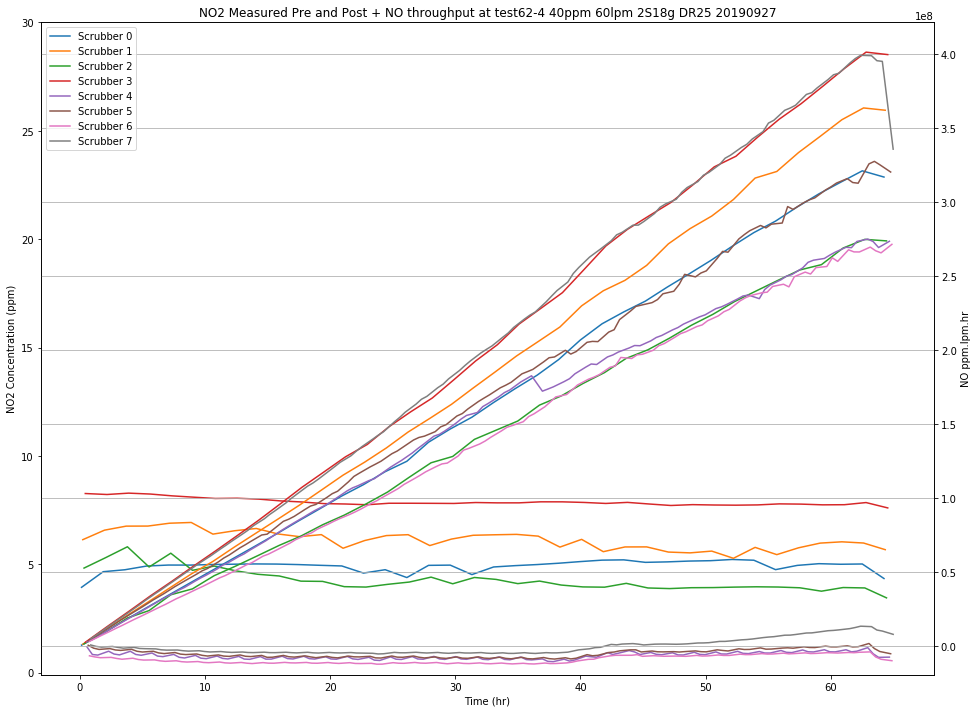

In [7]:
# 4.1 Plot Processed NO2 Data Cell

figure(figsize=(16,12))

a1 = gca()    # get the current axes and save as "a1"
a2 = a1.twinx()   # create a twin Y axis

for state in channel_states:
    a1.plot(prcd_data[state]['Time']/3600, prcd_data[state]['NO2'], label = Valve2Name_dict[state])
    a2.plot(prcd_data[state]['Time']/3600, ppm_lpm_hr[state]['ppm.lpm.hr'],label = (Valve2Name_dict[state]))
a1.set_xlabel('Time (hr)')
a1.set_ylim([-0.1,30])
a1.set_ylabel('NO2 Concentration (ppm)')
#a2.set_ylim([0,100000])
a2.set_ylabel('NO ppm.lpm.hr')
title('NO2 Measured Pre and Post + NO throughput' + ' at ' + graph_title)

legend()
grid(True)

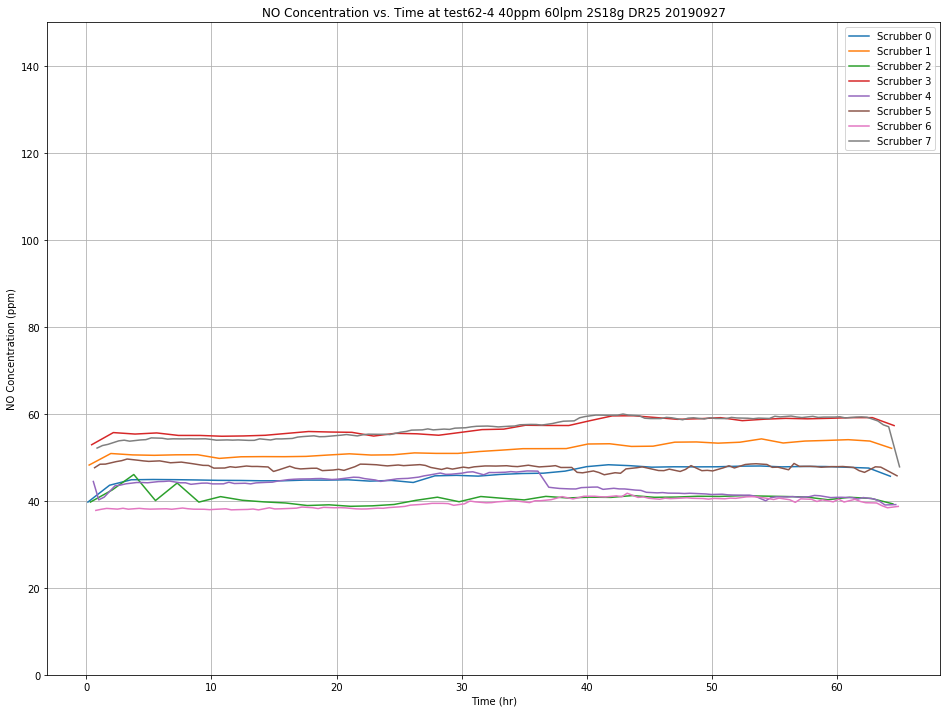

In [8]:
# 4.2 Plot Processed NO Data Cell

figure(figsize=(16,12))
for state in channel_states:
    plot(prcd_data[state]['Time']/3600, prcd_data[state]['NO'], label = Valve2Name_dict[state])
xlabel('Time (hr)')
ylabel('NO Concentration (ppm)')
ylim(0,150)
title('NO Concentration vs. Time' + ' at ' + graph_title)
legend()
grid(True)

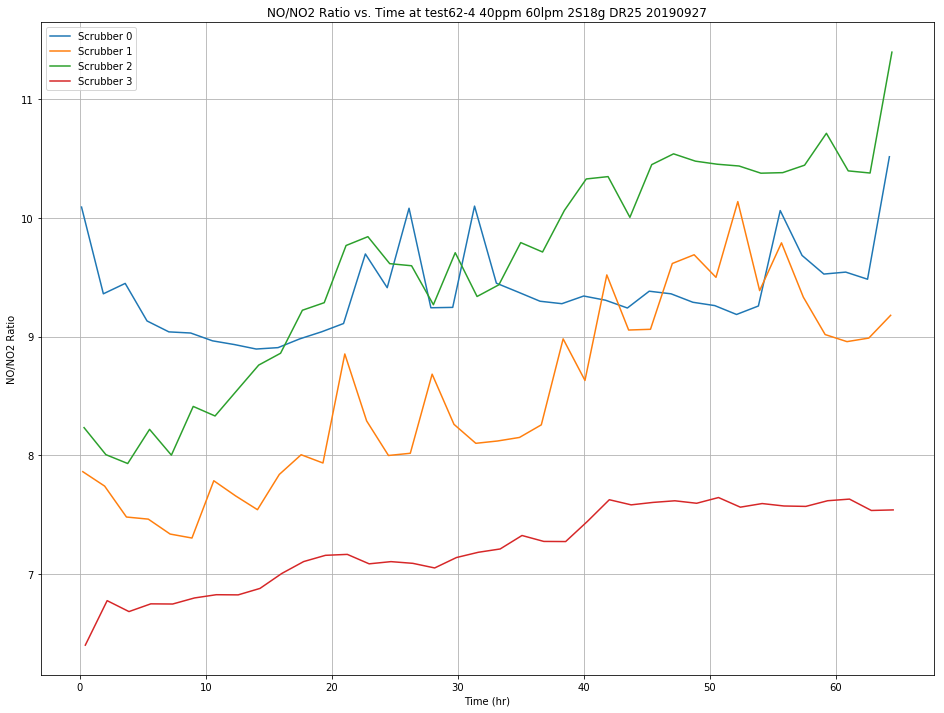

In [9]:
#Plot NO/NO2 Data

figure(figsize=(16,12))
for state in channel_states[0:4]:
    plot(prcd_data[state]['Time']/3600, prcd_data[state]['NO/NO2'], label = Valve2Name_dict[state])
xlabel('Time (hr)')
ylabel('NO/NO2 Ratio')
title('NO/NO2 Ratio vs. Time' + ' at ' + graph_title)
legend()
grid(True)

In [10]:
# 4.3 

pre_scrubber_channels = list(channel_states[0:int(len(channel_states)/2)])
post_scrubber_channels = list(channel_states[int(len(channel_states)/2):])
pre_post_prcd_data  = {k:{'Time':numpy.empty(allocation_size[k][0])*np.nan, 'Efficiency NO2':numpy.empty(allocation_size[k][0])*np.nan,'NO Loss':numpy.empty(allocation_size[k][0])*np.nan} for k in post_scrubber_channels}
position_dict_3 = {k:[0] for k in pre_scrubber_channels}
position_dict_4 = {k:[0] for k in post_scrubber_channels}

#print scrubber_channels
#print post_scrubber_channels
#print position_dict_3
#print position_dict_4
# 4.4 

for l in pre_scrubber_channels:
    for m in post_scrubber_channels:
        if pre_scrubber_channels.index(l) == post_scrubber_channels.index(m):
            for n in list(np.arange(allocation_size[m][0])):
                if position_dict_3[l][0] != allocation_size[l][0] - 1:
                    if prcd_data[l]['Time'][position_dict_3[l][0]] < prcd_data[m]['Time'][n] and prcd_data[l]['Time'][position_dict_3[l][0]+1] >= prcd_data[m]['Time'][n]:
                        pre_post_prcd_data[m]['Efficiency NO2'][n] = 100*(prcd_data[l]['NO2'][position_dict_3[l][0]] - prcd_data[m]['NO2'][n]) / prcd_data[l]['NO2'][position_dict_3[l][0]]
                        pre_post_prcd_data[m]['Time'][n] = prcd_data[m]['Time'][n]
                        #print (prcd_data[l]['NO2'][position_dict_3[l][0]] - prcd_data[m]['NO2'][n]) / prcd_data[l]['NO2'][position_dict_3[l][0]]
                        #print prcd_data[m]['NO2'][n]
                        pre_post_prcd_data[m]['NO Loss'][n] = (prcd_data[l]['NO'][position_dict_3[l][0]] - prcd_data[m]['NO'][n])
                        #/ prcd_data[l]['NO'][position_dict_3[l][0]]
                    else:
                        if position_dict_3[l][0] != allocation_size[l][0]-1:
                            position_dict_3[l][0] += 1
                            pre_post_prcd_data[m]['Efficiency NO2'][n] =100*(prcd_data[l]['NO2'][position_dict_3[l][0]] - prcd_data[m]['NO2'][n])/ prcd_data[l]['NO2'][position_dict_3[l][0]]
                            pre_post_prcd_data[m]['NO Loss'][n] = (prcd_data[l]['NO'][position_dict_3[l][0]] - prcd_data[m]['NO'][n])
                            pre_post_prcd_data[m]['Time'][n] = prcd_data[m]['Time'][n]               

#print position_dict_3
#print position_dict_4
print 'NO loss'
for m in post_scrubber_channels:
    print m
    print pre_post_prcd_data[m]['NO Loss']
    
print 'Efficiency NO2'
for m in post_scrubber_channels:
    print m
    print pre_post_prcd_data[m]['Efficiency NO2']

NO loss
16
[-4.73462583 -0.50764    -1.13222917  0.13103333 -0.02909833 -0.31931667
  0.63326083  0.63339417  0.69775833  0.48181333  0.44846583  0.35301333
  0.7176275   0.71793333  1.06910583  0.7366525   0.7198025   0.90595917
  0.80466417  0.43622583  0.72943917  0.64134083  0.78655417  0.55833167
  0.35916083  0.32550833  0.0657575  -0.26477833 -0.3530325  -0.41131917
 -0.28070333 -0.34228    -0.36250833 -0.14311417 -0.21209167 -0.35981333
 -0.59639    -0.54760917 -0.2763525  -0.26268583  0.07042417 -0.14818583
 -0.36355167 -0.42717083 -0.47053167 -1.23228    -1.52013917 -1.71926417
 -0.64003417 -0.33908167 -0.37081667 -0.501215   -0.73865583 -0.81468167
 -0.30565833 -0.83123417 -0.81661083 -0.5114875  -0.652635   -0.55001417
 -0.592195   -0.57378583 -0.54825167  3.23272083  3.38073833  3.5129025
  4.09140667  4.09739667  3.79384917  4.70972833  4.69157917  5.22229333
  5.41412     5.55827667  5.56806083  5.61155667  5.68262667  6.1200825
  5.90443583  5.84119833  5.96412833  6.08

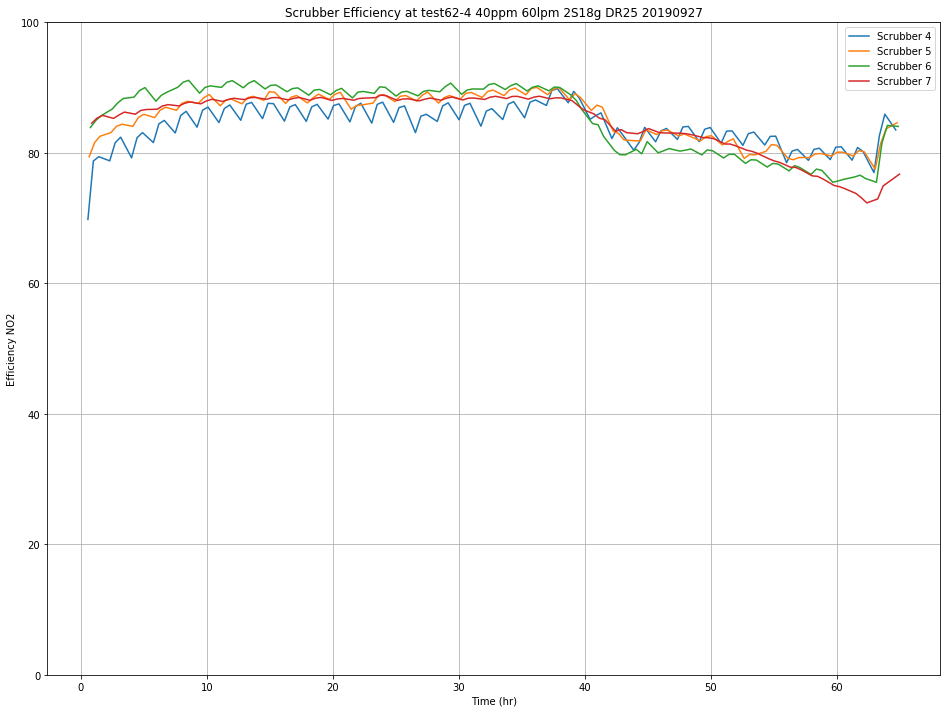

In [11]:
# Plot Efficiency

figure(figsize=(16,12))
for state in post_scrubber_channels:
    plot(pre_post_prcd_data[state]['Time']/3600, pre_post_prcd_data[state]['Efficiency NO2'], label = Valve2Name_dict[state])
xlabel('Time (hr)')
ylabel('Efficiency NO2')
ylim(0,100)
title('Scrubber Efficiency' + ' at ' + graph_title)
legend()
grid(True)

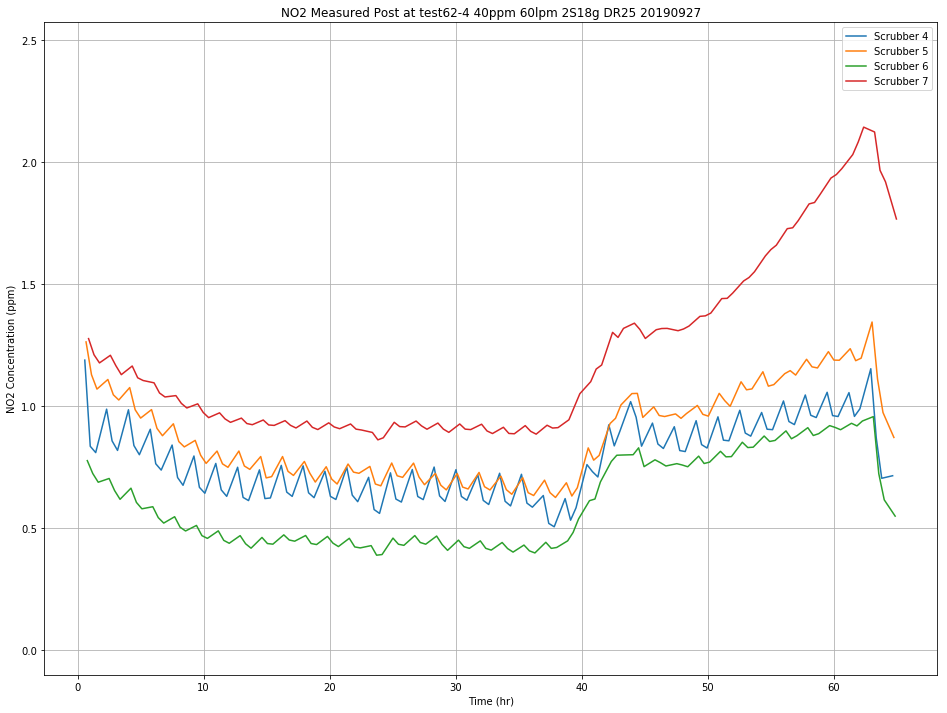

In [12]:
# Plot Processed NO2 Data Cell

figure(figsize=(16,12))
max_temp = []

for state in post_scrubber_channels:
    plot(prcd_data[state]['Time']/3600, prcd_data[state]['NO2'], label = Valve2Name_dict[state])
    max_temp.append(max(prcd_data[state]['NO2']))

    

xlabel('Time (hr)')
ylim([-0.1,1.2*max(max_temp)])
ylabel('NO2 Concentration (ppm)')
title('NO2 Measured Post' + ' at ' + graph_title)

legend()
grid(True)

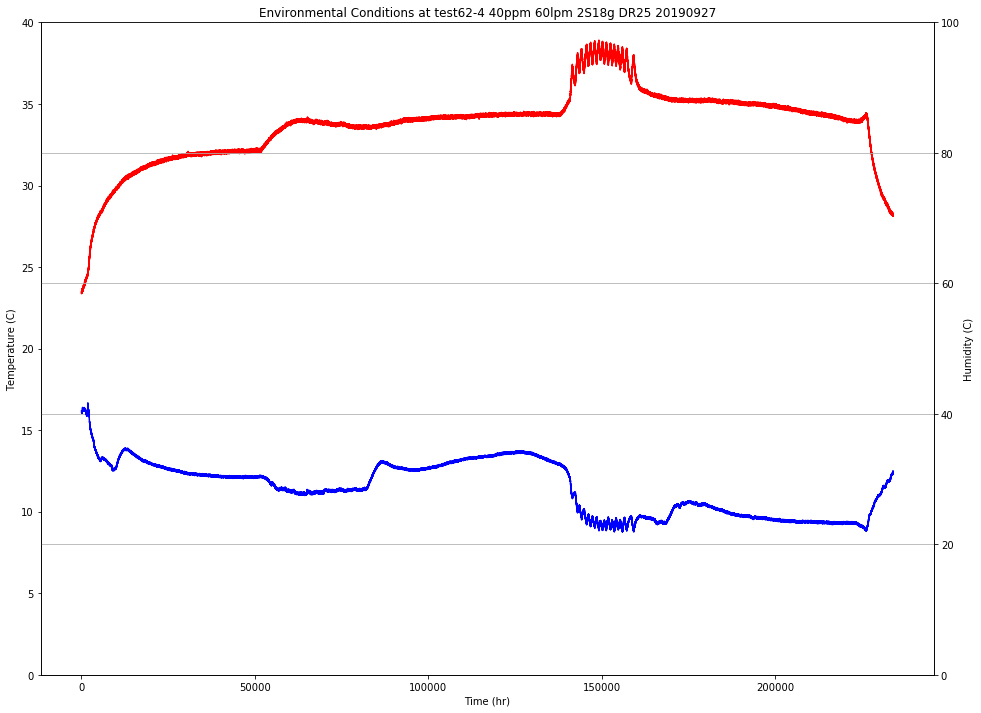

In [13]:
# Plot Envirnomental Conditions

figure(figsize=(16,12))
a1 = gca()    # get the current axes and save as "a1"
a2 = a1.twinx()   # create a twin Y axis

a1.plot(data['Elapsed Time'], data['hTemp'], 'r')
a2.plot(data['Elapsed Time'], data['Humid'], 'b')

a1.set_xlabel('Time (hr)')
a1.set_ylim([0,40])
a1.set_ylabel('Temperature (C)')
a2.set_ylim([0,100])
a2.set_ylabel('Humidity (C)')

title('Environmental Conditions' + ' at ' + graph_title)
grid(True)

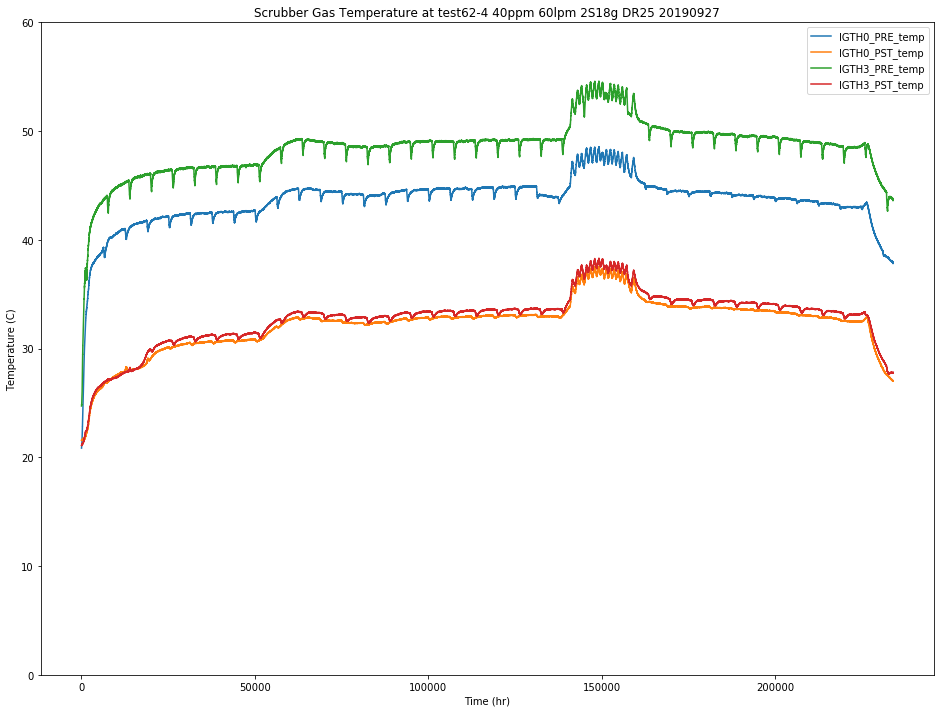

In [14]:
#Plot Scrubber (Gas Path) Temp

figure(figsize=(16,12))

plt_keys_temp = ['IGTH0_PRE_temp','IGTH0_PST_temp','IGTH3_PRE_temp','IGTH3_PST_temp',]
 
for i in plt_keys_temp:
    if i in data.keys():
        plot(data['Elapsed Time'],data[i], label = i)

xlabel('Time (hr)')
ylim([0,60])
ylabel('Temperature (C)')
title('Scrubber Gas Temperature' + ' at ' + graph_title)
legend()

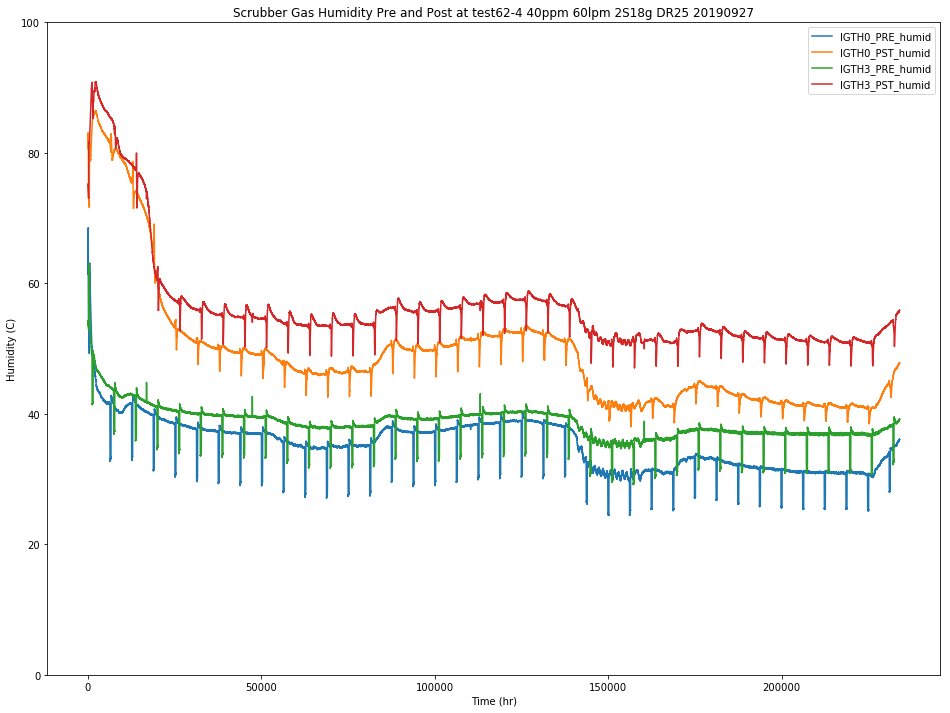

In [15]:
#Plot Scrubber (Gas Path) Humidity

figure(figsize=(16,12))

plt_keys_humid = ['IGTH0_PRE_humid','IGTH0_PST_humid','IGTH3_PRE_humid','IGTH3_PST_humid']
 
for j in plt_keys_humid:
    if j in data.keys():
        plot(data['Elapsed Time'], data[j], label = j)

xlabel('Time (hr)')
ylim([0,100])
ylabel('Humidity (C)')  
title('Scrubber Gas Humidity Pre and Post' + ' at ' + graph_title)
legend()

In [16]:
# 5.1 Prep for Data Export

Export_dict = OrderedDict({}) #create ordered dictionary for export
fieldnames = {'Time','NO','NO2'}

#This loop takes the dictionary of dictionaries and creates one dictionary 
for thekeys in channel_states:
    for data_names in fieldnames:
        Export_dict[Valve2Name_dict[thekeys] + ' ' + data_names] = prcd_data_export[thekeys][data_names]

#Exports the pandas Data Frame as a csv file
Export_df_avg = pandas.DataFrame(Export_dict)

In [25]:
Export_dict = OrderedDict({}) #create ordered dictionary for export
fieldnames = {'Time','Efficiency NO2','NO Loss'}

#This loop takes the dictionary of dictionaries and creates one dictionary 
for thekeys in post_scrubber_channels:
    for data_names in fieldnames:
        Export_dict[Valve2Name_dict[thekeys] + ' ' + data_names] = pre_post_prcd_data[thekeys][data_names]
        
#Exports the pandas Data Frame as a csv file
Export_df_pp = pandas.DataFrame(Export_dict)

In [26]:
# 5.2 Write Processed Data to File

write_file = filename.replace('.csv','') + '_averages_output.csv'
print write_file

Export_df_avg.to_csv(write_file)

write_file = filename.replace('.csv','') + '_prepost_output.csv'
print write_file

Export_df_pp.to_csv(write_file)

../Lab_Scripts_WI/data/scrubber_life/test62-4__40ppm__60lpm__2S18g__DR25__20190927_averages_output.csv
../Lab_Scripts_WI/data/scrubber_life/test62-4__40ppm__60lpm__2S18g__DR25__20190927_prepost_output.csv
